In [1]:
import matplotlib
%matplotlib inline
import pylab as pl
from IPython import display


class Person():
    def __init__(self, x, y, healthy=True, immune=False, quarantine_mode=0, MAX=1000, POPULATION=200):
        """
        x/y: location (between 0 and MAX)
        health: True/False
        immune: True/False
        quarantine_mode: 0 no quarantine
        """
        self.x = x
        self.y = y
        self.healthy = healthy
        self.immune = immune
        self.q = quarantine_mode
        self.symptoms = False
        self.days_sick = 0
        self.updated = False
        self.MAX = MAX
        self.START_POPULATION = POPULATION

        
class Disease():
    def __init__(self, contagion_rate=0.33, mortality=0., symptom_free=7, cure=14, contagious_radius=2):
        self.r0 = contagion_rate
        self.mortality = mortality
        self.symptoms = symptom_free  # number of days symptom free
        self.cure = cure # Number of days until cured
        self.contagious_radius = contagious_radius # How far it can contaminate)

import random
class Grid():
    def __init__(self, size):
        self.grid = []
        for i in range(size):
            row=[None,] * size
            self.grid.append(row)
        
    def __getitem__(self,args):
        x,y = args
        return self.grid[x][y]
    
    def __setitem__(self, args, value):
        x, y = args
        try:
            self.grid[x][y] = value
        except Exception as err:
            print(x,y,value)
            print(err)


def show_population(pop, day, save=False):
    pl.clf()
    healthy = [p for p in pop if p.healthy]
    sick = [p for p in pop if not p.healthy ]
    pl.scatter([p.x for p in pop], 
                [p.y for p in pop],
                s=[5 if not p.healthy else 3 if p.immune else 1 for p in pop],
                c= ["red" if not p.healthy else 'green' if p.immune else 'blue' for p in pop],
                marker='o', 
                #cmap=None, 
                linestyle = 'solid',
                linewidths=1,
                #edgecolors=["grey" if p.health else 'black' for p in pop],
                )
    n = sum([p.healthy for p in pop])
    imm = sum([p.immune for p in pop])
    pl.title(f"Day:  {day:.2f}, Healthy: {n}, Population: {len(pop)}, Immune: {imm}, Dead: {pop[-1].START_POPULATION - len(pop)}")
    
    if save:
        pl.savefig(f"contagion_{int(day*100):07d}.png")
    
    display.display(pl.gcf())
    display.clear_output(wait=True)
    

In [2]:
def find_neighbours(p, radius=2):
    neighbours = []
    for x in range(p.x-radius, p.x+radius+1):
        if x < 0 or x>=MAX:
            continue
        for y in range(p.y-radius, p.y+radius+1):
            if y<0 or y>=p.MAX or (p.x==x and p.y==y):
                continue
            if grid[x,y] is not None:
                neighbours.append(grid[x,y])
    return neighbours

def update(pop, delta = .25, radius=5):
    deads = []
    for i, p in enumerate(pop):
        if p.healthy:
            if not p.immune:
                # ok let's see if we get contaminated
                N = find_neighbours(p, D.contagious_radius)
                if len(N) > (D.contagious_radius+3)**2 -1:
                    raise Exception(f"OOOPSIE {len(N)}")
                for n in N:
                    if not n.healthy:
                         # Ohoh he's sick
                        if random.random() < D.r0:
                            # Doh contaminated!
                            p.healthy = False
        else: # Ok sick person let's see
            p.days_sick += delta
            if p.days_sick >= D.cure:
                p.healthy=True
                p.immune = True
            if p.days_sick >= D.symptoms:
                p.symptoms = True
            if random.random() < D.mortality/D.cure*delta: # Mortality is % over the length of the disease
                deads.append(i)
        # Let's move that person
        move = True
        while move:
            dx = random.randint(-radius,radius)
            dy = random.randint(-radius,radius)
            new_x = p.x + dx
            if new_x >= p.MAX:
                new_x = p.MAX-1
            if new_x < 0:
                new_x = 0
            new_y = p.y + dy
            if new_y < 0:
                new_y =0
            if new_y >= p.MAX:
                new_y = p.MAX - 1
            if new_x == p.x and new_y == p.y:
                continue
            if grid[new_x, new_y] is not None:
                # someone is there
                continue
            grid[p.x, p.y] = None
            p.x = new_x
            p.y = new_y
            grid[p.x, p.y] = p
            move = False
    for index in sorted(deads)[::-1]:
        pop.pop(index)
    return pop

In [5]:
cont = True
delta = 1/24.
D = Disease(contagion_rate=0.83, mortality=0.1, symptom_free=7, cure=25, contagious_radius=5)
MAX = 1000
POPULATION = 500
grid = Grid(MAX)
start_sick = 15
movement_radius = 10
pop = []
n_sick = 0
for i in range(POPULATION):
    pop.append(Person(x=random.randint(0,MAX), y=random.randint(0, MAX), MAX=MAX, POPULATION=POPULATION))
    if i<start_sick:
        pop[-1].healthy = False
        pop[-1].disease = D
        n_sick += 1
    grid[pop[-1].x, pop[-1].y] = pop[-1]
    

34 1000 <__main__.Person object at 0x7f4ecd235cd0>
list assignment index out of range
505 1000 <__main__.Person object at 0x7f4ecd2abc10>
list assignment index out of range


World is disease free with death rate: 0.10199999999999998


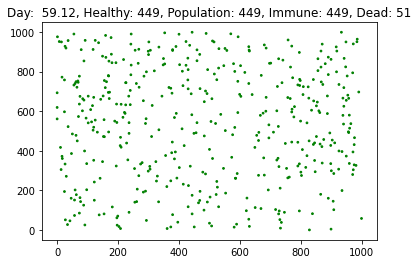

In [6]:
t = 0
while cont:
    show_population(pop, t, save=True)
    update(pop, delta = delta, radius=movement_radius)
    healthy= sum([p.healthy for p in pop])
    n = len(pop)
    if n == 0 or healthy == len(pop):
        cont = False
    t += delta

show_population(pop, t)
if n == 0:
    print("Everyone died")
else:
    print(f"World is disease free with death rate: {1. - float(healthy)/POPULATION}")